# 4-1. 프로젝트: 인물 모드 문제점 찾기

In [10]:
from importlib.metadata import version
from matplotlib import pyplot as plt
from pixellib.semantic import semantic_segmentation

import cv2
import pixellib
import numpy as np

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## Step 1. 인물모드 직접 해 보기

- 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

### 모델 준비

In [11]:
# 모델 인스턴스 생성
model = semantic_segmentation()

In [13]:
model_path = "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
model.load_pascalvoc_model(model_path)

In [39]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [52]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]


def get_color(label):
    r, g, b = colormap[LABEL_NAMES.index(label)]
    return [b, g, r]

In [53]:
get_color("person")

[128, 128, 192]

### 아웃포커싱(인물모드) 적용

In [148]:
def camera_mode(img_path, focus='person', blur=(10, 10), removeBG=False):
    # 원본 이미지 저장
    img_orig = cv2.imread(img_path)
    
    # segmentation 진행
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    # Mask 생성
    seg_map = np.all(output==get_color(focus), axis=-1)
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    
    # Blur 처리
    img_orig_blur = cv2.blur(img_orig, blur)
    
    # Blur영역과 Focus영역 합치기
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    if removeBG:
        empty_img = np.zeros(img_orig.shape, dtype=img_orig.dtype)
        img_concat = np.where(img_mask_color==255, img_orig, empty_img)
    
    
    return img_orig, img_concat

In [129]:
before, after = camera_mode('./img/1.jpg')

In [127]:
def compare_show(imgs, size=(15, 20), vertical=True):
    # imgs의 인자는 원본, 적용결과물 순서로 총 2개
    
    plt.figure(figsize=size)
    
    # vertical 옵션에 따라 값 변경
    h, v = (1, 2) if vertical else (2, 1)
    
    
    for i in range(2):
        plt.subplot(h, v, i+1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    
    plt.show()

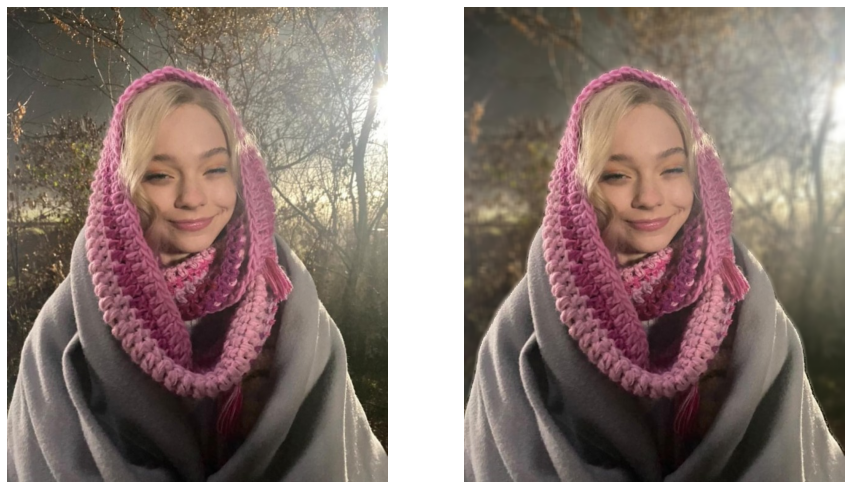

In [130]:
compare_show([before, after])

---

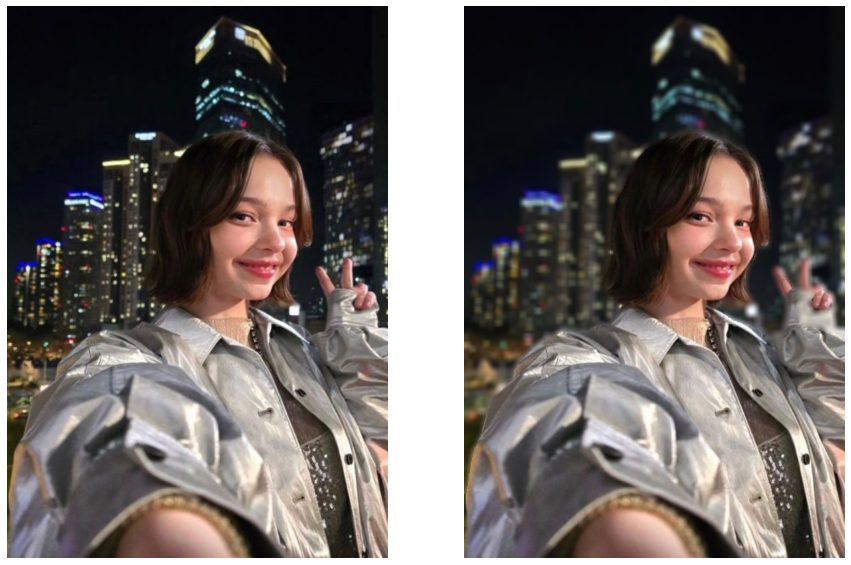

In [147]:
compare_show(camera_mode('./img/2.jpg'))

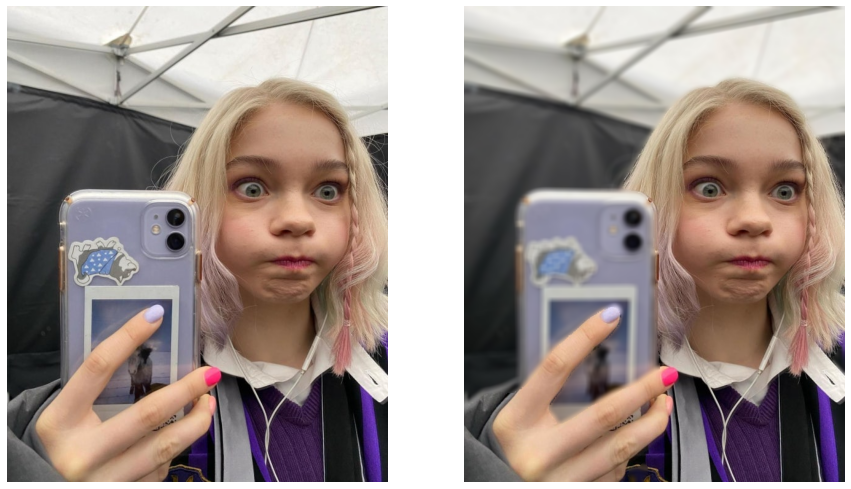

In [132]:
compare_show(camera_mode('./img/3.jpg'))

---

### 아웃포커싱(인물모드) 고양이에 적용

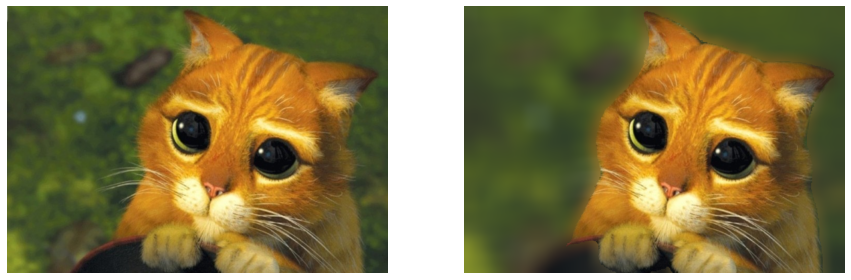

In [137]:
compare_show(camera_mode('./img/cat1.jpg', focus='cat', blur=(50, 50)))

### 아웃포커싱(인물모드) 강아지에 적용

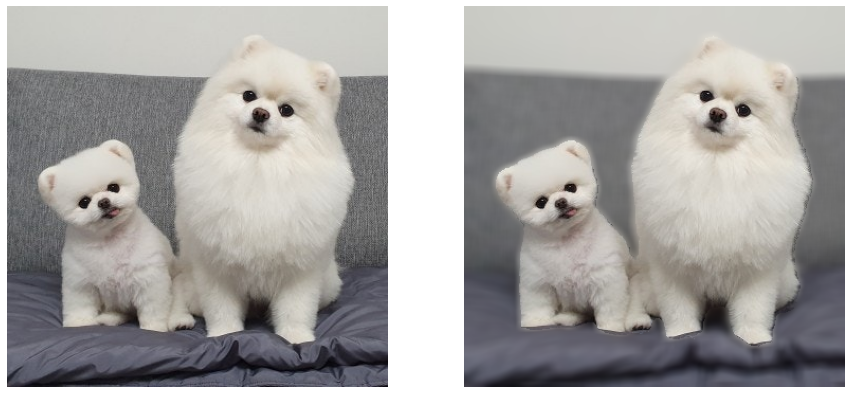

In [139]:
compare_show(camera_mode('./img/dog1.jpg', focus='dog'))

- 블러 효과 좀 더 강하게 적용

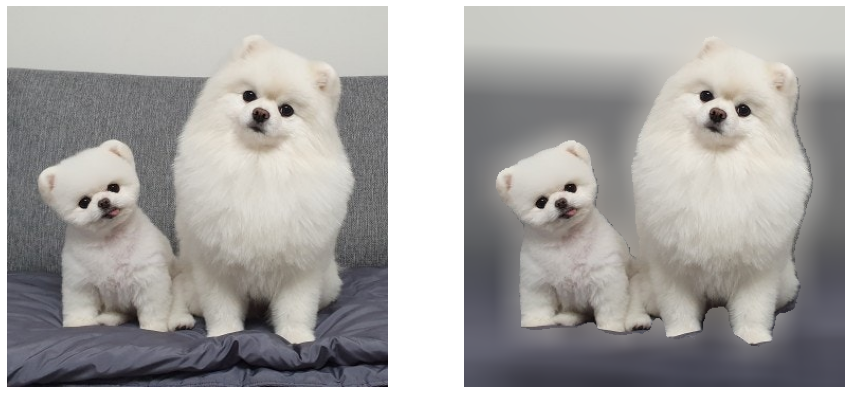

In [138]:
compare_show(camera_mode('./img/dog1.jpg', focus='dog', blur=(50, 50)))

### 배경합성 적용

- 인물의 배경 제거

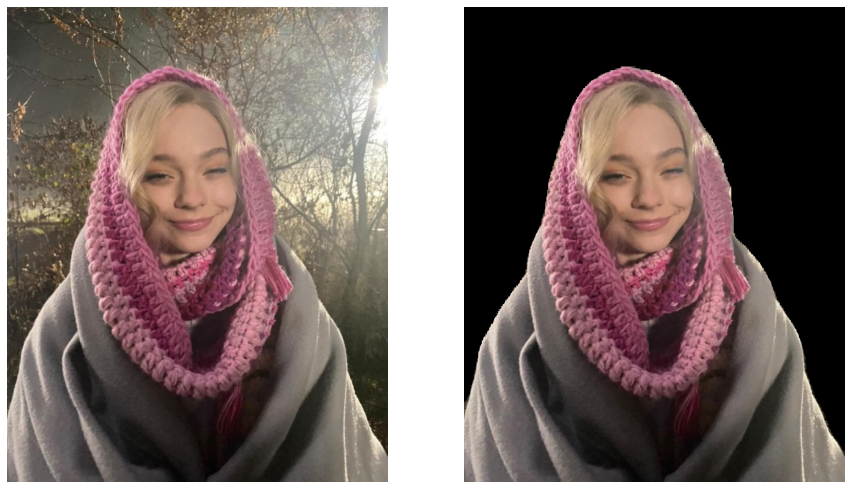

In [242]:
before, noBG = camera_mode('./img/1.jpg', removeBG=True)

compare_show([before, noBG])

In [243]:
noBG.shape

(774, 620, 3)

- 새로운 배경

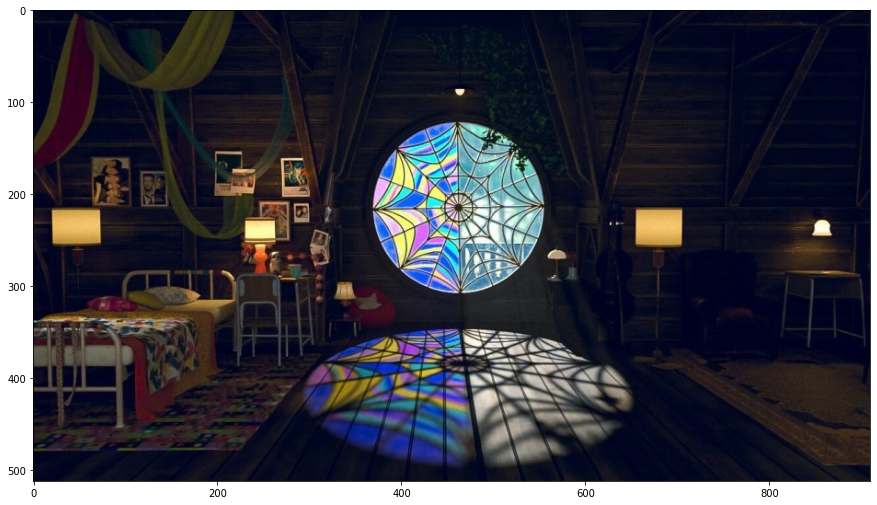

In [244]:
new_bg = cv2.imread('./img/bg2.jpg')

plt.figure(figsize=(15, 20))
plt.imshow(cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB))
plt.show()

In [245]:
new_bg.shape

(512, 910, 3)

- 배경 사이즈에 맞게 인물 사이즈 수정

In [246]:
h = int(noBG.shape[0] / 2)
w = int(h * (noBG.shape[1] / noBG.shape[0]))

h, w

(387, 310)

In [247]:
onlyPerson = cv2.resize(noBG, (w,h))
onlyPerson.shape

(387, 310, 3)

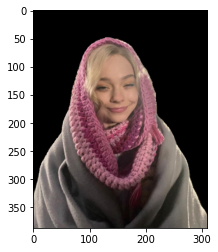

In [248]:
plt.imshow(cv2.cvtColor(onlyPerson, cv2.COLOR_BGR2RGB))
plt.show()

- 인물이 놓일 위치 선정

In [249]:
# 중앙 하단
overlay_y = new_bg.shape[0] - onlyPerson.shape[0]
overlay_x = new_bg.shape[1] // 2 - onlyPerson.shape[1] // 2
overlay_h = overlay_y + onlyPerson.shape[0]

overlay_y, overlay_x, overlay_h

(125, 300, 512)

- 새 배경 위에 인물 덮어쓰기

In [250]:
person_area = new_bg[overlay_y:overlay_y + onlyPerson.shape[0], overlay_x:overlay_x+onlyPerson.shape[1]]
new_bg[overlay_y:overlay_y + onlyPerson.shape[0], overlay_x:overlay_x+onlyPerson.shape[1]] = \
    np.where(onlyPerson==0,person_area,onlyPerson).astype(np.uint8)


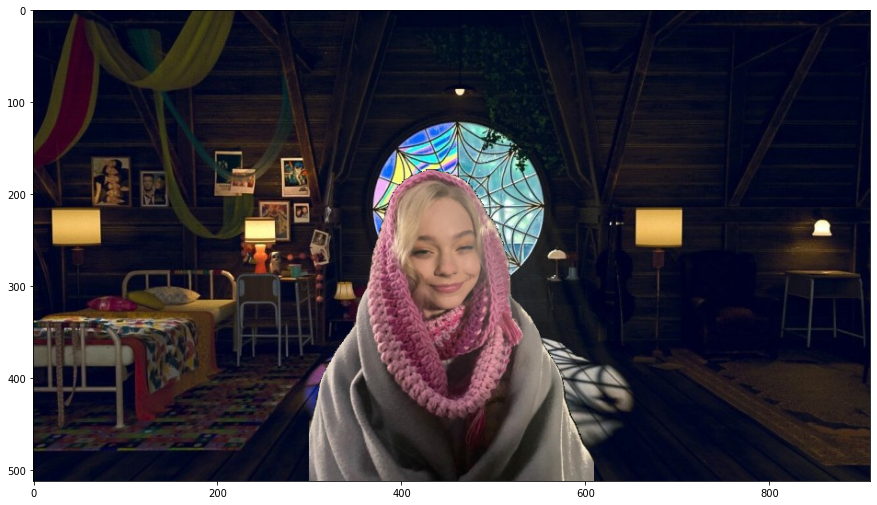

In [251]:
plt.figure(figsize=(15, 20))
plt.imshow(cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기

- 제시된 사진의 추가 문제점 찾기

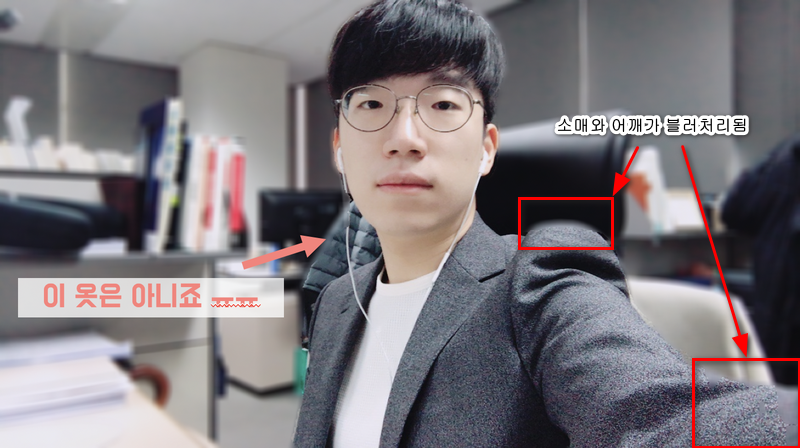

- 직접 만든 인물 모드 사진 중 하나에서도 이상한 위치 표시

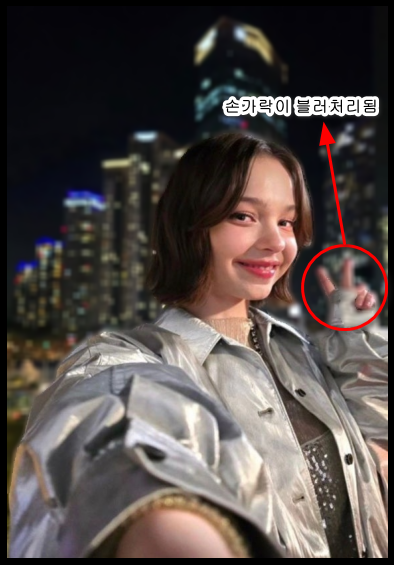

## Step 3. 해결 방법을 제안해 보기

### 1. 소프트웨어 개선 방안

#### 1-1. 다른 모델 사용하기

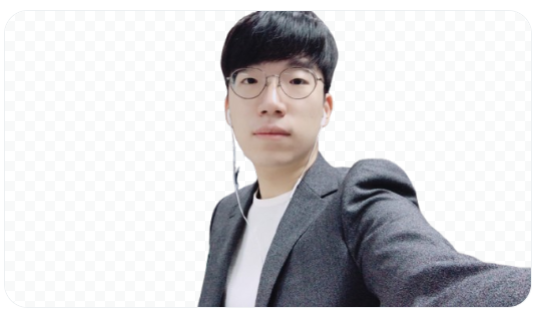

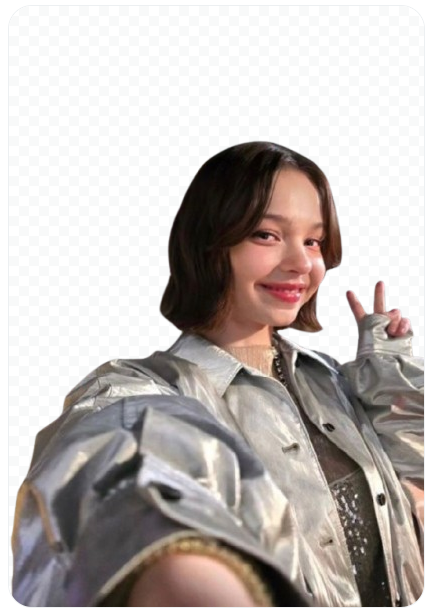

- 같은 사진을 다른 배경제거 알고리즘을 사용하는 서비스에 적용해본 결과 깔끔하게 문제없이 배경이 제거된 모습을 확인했다.

- 즉, 해당 프로젝트에서 사용한 모델의 성능이 떨어지는 것이 문제이기 때문에 더 나은 성능의 모델을 사용하면 된다.

- 여기서 사용한 모델 외에도 pixellib에서는 다양한 segmentation 모델을 제공하고 있다. 

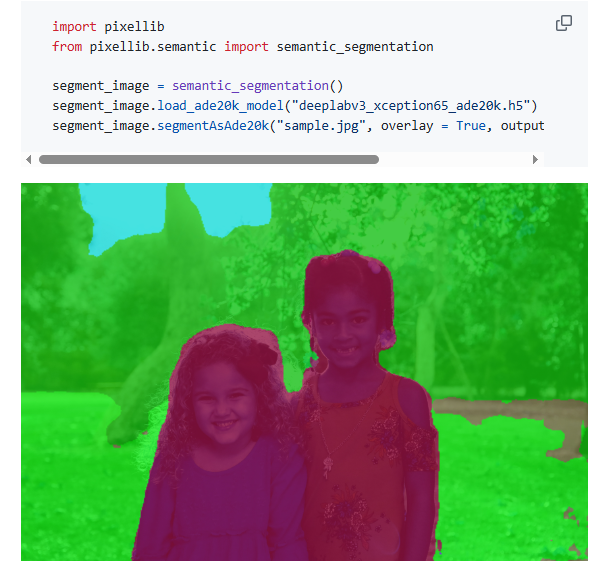

- 다만 위 스크린샷에서 알 수 있듯이 여러 모델의 데모를 확인해봤지만 그 성능이 이번 프로젝트에서 발견한 문제점을 해결할 정도는 아닌 것 같다.

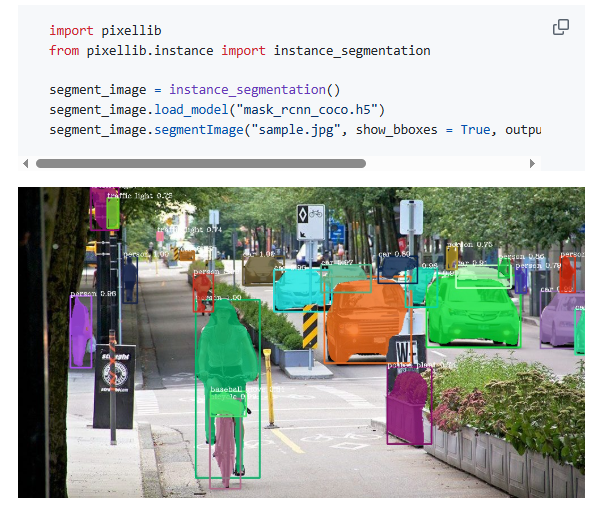

- 위 스크린샷은 MS COCO 데이터셋으로 훈련된 모델이지만 역시만 유사한 문제가 보인다.

- 아마도 비교적 작은 모델이기 때문일 수 도 있으므로 좀 더 성능이 좋은 비교적 큰 규모의 모델을 알아보는 것도 방법이겠다.
    - pixellib 보다는 YOLO, One-Peace, SAM 등의 모델을 활용해보는 방법이 있겠다.

#### 1-2. 직접 모델 만들기

- 마땅한 오픈 소스 모델이 없다면 직접 만드는 수밖에!!

- 모델링에도 신경써야겠지만 데이터셋을 좀 더 보강하는 것에 더 신경써야 할지도 모르겠다.
- Pascal VOC, MS COCO 등의 데이터의 라벨들을 보면 다소 대충한 느낌들이 꽤 있는데 이런 부분을 보강하여 학습에 적용하면 좀 더 나은 모델이 나올 것 같다.
    - 다만, 엄청난 시간과 노력이 필요할 것.

#### 1-3. 한계점

- 이러한 소프트웨어적인 한계는 분명하다. 원하는 모델을 라이선스등의 문제로 사용할 수 없거나, 모델이 너무 무거운 경우 실제 환경에서 사용할 장치의 성능이 해당 모델을 감당하지 못할 수 있다.
    
- 또한 위와 같은 문제점에서 적당한 타협점을 찾는다해도 픽셀단위 Segmentation에서 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘들다.

### 2. 하드웨어 개선 방안

#### 2-1. 카메라 렌즈를 이용한 진짜 인물 사진 모드(아웃포커싱) 사용

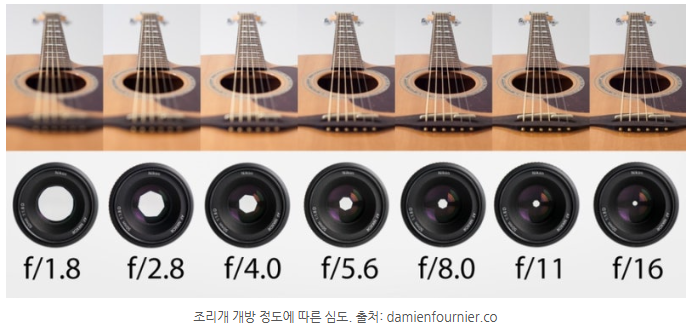

- 아웃포커싱을 하는 본래의 방식은 카메라의 조리개(렌즈의 유효 직경을 조절해주는 장치)를 조절하는 방식이다.

- 위 사진에서 볼 수 있듯이 조리개를 크게하는지 작게 하는지에 따라 초점을 맞추는 거리가 달라진다.

- 실제 스마트폰 카메라에도 이 방식이 가능하다.

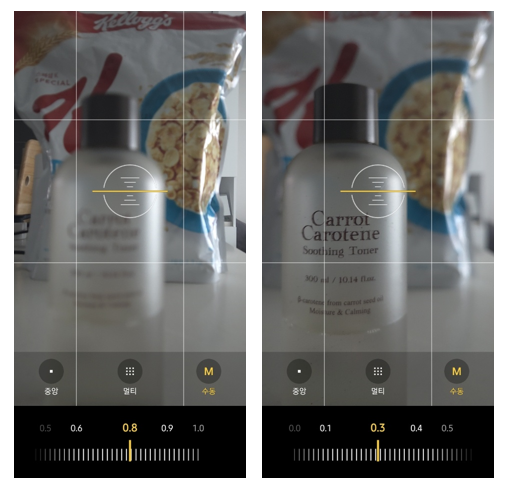

- 위 사진은 직접 스마트폰 카메라 기본 앱에서 조리개값을 조절하는 모습을 캡쳐한 사진이다.

- 왼쪽 사진은 조리개값을 0.8로 두어 가까운 피사체의 초점은 맞지 않는 대신 뒤에 더 멀리 있는 피사체에 초점이 맞고 있다.
- 반대로 조리개값을 0.3으로 줄이자 가까운 피사체에 초점이 맞고 멀리 있는 피사체는 초점이 맞지 않아 흐려진 모습이다.

### 3. 하드웨어, 소프트웨어 혼합 방식

이번 프로젝트 제목은 인물 사진 모드이지만 사실 이번에 우리가 학습하고자 하는 주제는 Segmentation이라고 할 수 있다.
Segmentation을 통해 인물 사진 모드를 만들며 그 한계, 문제점을 확인했다. 이를 해결하는 방법으로 조리개 조절은 Segmentation과 크게 상관이 있다고 보기 힘들다. 다음은 Segmentation 문제를 해결하는 방법을 좀 더 알아본 결과이다.

#### 3-1. Depth Camera 활용 (적외선 센서 활용)

- Depth Camera는 RGB 카메라와 적외선 센서가 혼합된 카메라이다.
- 카메라 렌즈가 피사체의 RGB 색상값을 수집하는 동시에 적외선을 발사하고 반사된 적외선이 다시 센서로 돌아오는 시간을 측정하여 이미지 내 각 부분의 거리를 계산하여 저장한다.
- 이렇게 각각의 피사체와의 거리를 알 수 있게 되었으므로 사물에 거리에 따라 Segmentation을 하여 위 문제 사진과 같은 소매나 손가락이 잘리는 현상을 개선할 수 있다.

#### 3-2. Lidar Sensor 활용

- 적외선 센서를 활용하는 것과 유사한 방식이라고 할 수 있다.
- 차이점은 적외선이 아닌 레이저를 발사하여 거리를 측정한다.
- 적외선 센서보다 오차가 적어 보다 정확한 거리를 기준으로 Segmentation이 가능해진다.
- 가정용 로봇청소기나 자율 주행 차량에서 Lidar센서를 활용하여 자신과 주변 사물과의 거리를 계산할 때 사용하는 만큼 그 정확도가 높다.

3-3. 여러 대의 카메라를 활용

- 인간은 두 개의 눈으로 동시에 같은 곳을 바라보며 얻은 두 개의 이미지를 뇌에서 계산하여 그 거리를 대략적으로 예측한다.
- 이와 같은 방식으로 동시에 여러 대의 나란히 같은 곳을 바라보며 촬영하다. 그 각각의 이미지는 카메라의 위치가 물리적으로 조금씩 다르므로 사물의 위치 변화가 일어나게 된다. 그리고 이러한 변화는 원근법에 의해 거리에 따라 차이가 나게 되고 이를 계산하여 각 피사체의 거리를 계사하는 방식이다.
- 테슬라에서 한 때 고집했던 방식이다. 다만, 결국 테슬라에서 Lidar센서를 활용하기로 한 만큼 정확도는 떨어진다.
- 그러나 위에서 언급한 다른 방식보다 훨씬 비용측면에서 유리하기 때문에 각 상황에 맞게 활용하면 Segmentation의 한계를 적절히 극복할 수 있는 해결 방안이 될 수 있을 것이다.

# 회고

- Segmentation을 활용하는 사례를 직접 실습해보며 익힐 수 있다는 점이 좋았다.
- 현실에서 인지하지도 못하고 사용하는 이런 인공지능 기술들이 있다는 것을 새삼 느끼고 이후 프로젝트를 주제를 선정하는 것에 좀 더 넓은 범위에서 생각할 수 있게 된 것 같다.
- 또한 해결 방안을 찾는 과정에서 역시 다양한 문제를 해결하기 위해 인공지능 분야에서도 다양한 장치 들을 활용하는 사례를 확인할 수 있었어 좋은 공부가 되었다. (예: 3D Pose Estimation 등등)